In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/philippe/MolGenDocking


/home/philippe/miniconda3/envs/MolGen/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Loading

In [189]:
from pathlib import Path
import json
import re

import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import roc_curve, roc_auc_score
from notebooks.utils import PandasTableFormatter
from mol_gen_docking.evaluation.diversity_aware_top_k import diversity_aware_top_k
from notebooks.utils import *

FIG_PATH = "MolGenDocking-latex/Figures/Results/MolProp"
os.makedirs(FIG_PATH, exist_ok=True)


In [238]:
MOLSTRAL_PATH = Path("MolGenOutput/polaris")

files = [f for f in MOLSTRAL_PATH.iterdir() if "error" not in str(f) and str(f).endswith("scored.jsonl")]
files = [f for f in files if not any(avoid in f.name for avoid in ["MiniMax", "Next", "R1", "ether0"])]
files = sorted(files)
full_df = load_molprop_results(files)

100%|██████████| 5/5 [00:27<00:00,  5.45s/it]


In [247]:
from tqdm import tqdm
tqdm.pandas()

full_df = full_df.groupby(["Model", "prompt_id", "Task"]).head(5)
# For each model, drop tasks where not all prompt_ids appear
# Get the set of prompt_ids per task (reference)
prompt_ids_per_task = full_df.groupby("Task").prompt_id.apply(set)
# Get the set of prompt_ids per (Model, Task)
prompt_ids_per_model_task = full_df.groupby(["Model", "Task"]).prompt_id.apply(set)
# Check which (Model, Task) combinations have all prompt_ids
valid_model_tasks = prompt_ids_per_model_task.reset_index()
valid_model_tasks["all_prompts"] = valid_model_tasks.apply(
    lambda x: x.prompt_id == prompt_ids_per_task[x.Task], axis=1
)
valid_model_tasks = valid_model_tasks[valid_model_tasks["all_prompts"]][["Model", "Task"]]
# Filter using merge (much faster than row-wise apply)
full_df = full_df.merge(valid_model_tasks, on=["Model", "Task"], how="inner")


In [248]:
df_validity_no_numeric_mistake = full_df.groupby(["Model", "prompt_id", "Task", "objectives"])[["validity", "contains_numeric"]].apply(
    lambda x: any(x.validity) or not any(x.contains_numeric)
).reset_index().rename(columns={0: "non-valid-and-numeric"})

df_validity = full_df.groupby(["Model", "prompt_id", "Task", "objectives"]).validity.apply(
    lambda x: any(x)
).reset_index()

# Merge to get contains_numeric info
df_validity = df_validity.merge(
    df_validity_no_numeric_mistake,
    on=["Model", "prompt_id", "Task", "objectives"],
    how="left"
)


df_validity = df_validity.groupby(["Model", "Task", "objectives"])[["validity", "non-valid-and-numeric"]].mean().reset_index()
df_validity

,Model,Task,objectives,validity,non-valid-and-numeric
0,ChemDFM-R,ames,classification,1.000000,1.000000
1,ChemDFM-R,antiviral-potency,regression,0.960784,1.000000
2,ChemDFM-R,az-logd,regression,1.000000,1.000000
3,ChemDFM-R,az-ppb-clearance,regression,1.000000,1.000000
4,ChemDFM-R,bbb,classification,1.000000,1.000000
...,...,...,...,...,...
130,gemma-3,mic-clearance-az,regression,1.000000,1.000000
131,gemma-3,pgp,classification,1.000000,1.000000
132,gemma-3,pkis2-drewry,classification,0.988208,0.990566
133,gemma-3,solubility,regression,0.953037,0.992486


/tmp/ipykernel_221825/2508068100.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obj["missed"] = 1- df_obj["validity"]
/tmp/ipykernel_221825/2508068100.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obj["missed-and-numeric"] =1 - df_obj["non-valid-and-numeric"]
/tmp/ipykernel_221825/2508068100.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='rig

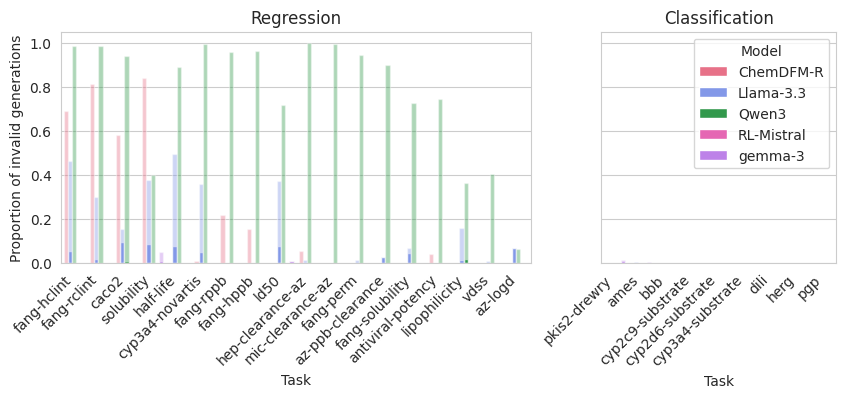

In [251]:
prop_cls = df_validity[df_validity.objectives == "classification"].Task.nunique() / df_validity.Task.nunique()/2

fig, axes = plt.subplots(1,2,figsize=(10,3), gridspec_kw={ "width_ratios": [1-prop_reg, prop_cls]}, sharey=True)

for obj, ax in zip(["regression", "classification"], axes):
    df_obj = df_validity[df_validity.objectives == obj]
    x_order = df_obj.groupby("Task").validity.mean().sort_values().index.tolist()
    df_obj["missed"] = 1- df_obj["validity"]
    df_obj["missed-and-numeric"] =1 - df_obj["non-valid-and-numeric"]
    kwargs = dict( data=df_obj, x="Task", hue="Model", palette=CMAP_MODELS, order=x_order, ax=ax,)
    sns.barplot(
        y="missed-and-numeric",
        legend=obj == "classification",
        alpha = 1,
        **kwargs
    )
    sns.barplot(
        y="missed",
        legend=False,
        alpha = 0.4,
        **kwargs
    )
    ax.set_title(obj.capitalize())
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    if ax == axes[0]:
        ax.set_ylabel("Proportion of invalid generations")
    else:
        ax.set_ylabel("")

fig.savefig(f"{FIG_PATH}/valid_.pdf", bbox_inches="tight")

# Metric Computation

## Regression

In [106]:
# Compute Spearman_corr
df = full_df[full_df.objectives == "regression"]
def get_yagg(values):
    values = [v for v in values if not np.isnan(v)]
    if len(values) == 0:
        return np.nan
    return np.mean(values)

df["y_agg"] = df.groupby(["Model", "prompt_id"]).y.transform(get_yagg)
correlations = df[df.validity == 1].groupby(["Model", "Task"])[["gt", "y_agg"]].corr(method="spearman").loc[pd.IndexSlice[:, :, "gt"], "y_agg"]
correlations = correlations.reset_index(level=2, drop=True)

coverage = df.groupby(["Model", "Task"]).validity.mean()

corr_cov_score = (correlations+1) * coverage / 2
corr_cov_score.fillna(0, inplace=True)

corr_cov_score

/tmp/ipykernel_221825/787785677.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_agg"] = df.groupby(["Model", "prompt_id"]).y.transform(get_yagg)


Model      Task             
ChemDFM-R  antiviral-potency    0.362503
           az-logd              0.857419
           az-ppb-clearance     0.469062
           caco2                0.070401
           cyp3a4-novartis      0.445472
                                  ...   
gemma-3    ld50                 0.248516
           lipophilicity        0.632737
           mic-clearance-az     0.622701
           solubility           0.469576
           vdss                 0.563282
Length: 167, dtype: float64

## Classification

In [107]:
df = full_df[full_df.objectives == "classification"]

def get_yagg(values):
    values = [v for v in values if not np.isnan(v)]
    if len(values) == 0:
        return np.nan
    return np.round(np.mean(values) + 1e-8 * values[0]).clip(0,1)

df["y_agg"] = df.groupby(["Model", "Task", "prompt_id"]).y.transform(get_yagg)

accuracy = df[df.validity == 1].groupby(
    ["Model", "Task"]
)[["gt", "y_agg"]].apply(
    lambda x: np.nanmean((x["gt"]== x["y_agg"]))
)
coverage = df.groupby(["Model", "Task"]).validity.mean()
accuracy = accuracy * coverage
accuracy.fillna(0, inplace=True)

accuracy

/tmp/ipykernel_221825/4145113119.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_agg"] = df.groupby(["Model", "Task", "prompt_id"]).y.transform(get_yagg)


Model      Task            
ChemDFM-R  ames                0.483262
           bbb                 0.716923
           cyp2c9-substrate    0.822430
           cyp2d6-substrate    0.700935
           cyp3a4-substrate    0.476636
                                 ...   
gemma-3    cyp3a4-substrate    0.530841
           dili                0.502632
           herg                0.721905
           pgp                 0.498462
           pkis2-drewry        0.142925
Length: 87, dtype: float64

## Add to table

In [273]:
# Join regression metrics
reg_metric = corr_cov_score.reset_index().rename(columns={0: "Metric"})
cls_metric = accuracy.reset_index().rename(columns={0: "Metric"})

full_df = full_df.drop(columns=["Metric"], errors="ignore")
full_df = full_df.merge(
    pd.concat([reg_metric, cls_metric]),
    on=["Model", "Task"],
    how="left"
)
full_df

,prompt_id,reward,gt,y,norm_var,model,n_props,properties,objectives,validity,Task,match,contains_numeric,gen_id,Model,Metric
0,novartis:novartis-cyp3a4-v1_train_15,-42.478431,-2.172000,-0.1177,0.311549,ChemDFM-R-14B_,1,novartis/novartis-cyp3a4-v1,regression,True,cyp3a4-novartis,\n-0.1177\n,True,0,ChemDFM-R,0.445472
1,novartis:novartis-cyp3a4-v1_train_15,0.000000,-2.172000,NaN,0.311549,ChemDFM-R-14B_,1,novartis/novartis-cyp3a4-v1,regression,False,cyp3a4-novartis,\nNo\n,False,1,ChemDFM-R,0.445472
2,novartis:novartis-cyp3a4-v1_train_15,-34.482031,-2.172000,-0.3162,0.311549,ChemDFM-R-14B_,1,novartis/novartis-cyp3a4-v1,regression,True,cyp3a4-novartis,\n-0.3162\n,True,2,ChemDFM-R,0.445472
3,novartis:novartis-cyp3a4-v1_train_15,-56.839283,-2.172000,0.1974,0.311549,ChemDFM-R-14B_,1,novartis/novartis-cyp3a4-v1,regression,True,cyp3a4-novartis,\n0.1974\n,True,3,ChemDFM-R,0.445472
4,novartis:novartis-cyp3a4-v1_train_15,-23.497111,-2.172000,-0.6300,0.311549,ChemDFM-R-14B_,1,novartis/novartis-cyp3a4-v1,regression,True,cyp3a4-novartis,\n-0.6300\n,True,4,ChemDFM-R,0.445472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335620,biogen:adme-fang-rppb-reg-v1_train_108,-2.236208,-0.742321,0.6000,0.746171,gemma-3-27b-it_,1,biogen/adme-fang-rppb-reg-v1,regression,True,fang-rppb,0.6,True,2,gemma-3,0.468317
335621,biogen:adme-fang-rppb-reg-v1_train_108,-35.246408,-0.742321,3.7500,0.746171,gemma-3-27b-it_,1,biogen/adme-fang-rppb-reg-v1,regression,True,fang-rppb,3.0-4.5,True,3,gemma-3,0.468317
335622,biogen:adme-fang-rppb-reg-v1_train_108,-16.734728,-0.742321,2.4000,0.746171,gemma-3-27b-it_,1,biogen/adme-fang-rppb-reg-v1,regression,True,fang-rppb,2.4,True,4,gemma-3,0.468317
335623,biogen:adme-fang-rppb-reg-v1_train_108,-10.608717,-0.742321,1.8000,0.746171,gemma-3-27b-it_,1,biogen/adme-fang-rppb-reg-v1,regression,True,fang-rppb,1.8,True,0,gemma-3,0.468317


# Plots

In [274]:
KEY = "Metric"
table = full_df.groupby(["Model", "Task", "objectives"])[KEY].mean().reset_index()
MODEL_ORDER = list(CMAP_MODELS.keys())

task_order = table.groupby(["Model", "Task"])[KEY].mean().reset_index().groupby("Task")[KEY].max().sort_values( ascending=False).index

table = table.set_index(["Task"]).loc[task_order].reset_index()
table

,Task,Model,objectives,Metric
0,az-logd,ChemDFM-R,regression,0.857419
1,az-logd,Llama-3.3,regression,0.302410
2,az-logd,Qwen3,regression,0.300612
3,az-logd,RL-Mistral,regression,0.643487
4,az-logd,gemma-3,regression,0.575084
...,...,...,...,...
130,fang-solubility,ChemDFM-R,regression,0.328980
131,fang-solubility,Llama-3.3,regression,0.430831
132,fang-solubility,Qwen3,regression,0.030315
133,fang-solubility,RL-Mistral,regression,0.434603


# Heatmap

In [275]:
MODEL_ORDER = full_df[full_df.objectives == "regression"].groupby("Model")[KEY].mean().sort_values().index.tolist()

In [276]:
def plot_heatmap(table, axes, title_name, split_val, vmin=0, vmax=1, annot_size=10):
    ax = axes[0]
    pivoted = pd.pivot_table(table[table.objectives == split_val], KEY, "Model", "Task")
    col_order = pivoted.max().sort_values(ascending=False).index
    pivoted = pivoted.loc[MODEL_ORDER,col_order]
    sns.heatmap(
        pivoted,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        annot=True,
        fmt=".2f",
        annot_kws={"size": annot_size}
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(rotation=90, ha='center', labels=ax.get_xticklabels())
    ax.set_title(title_name)

    ax = axes[1]
    pivoted = pd.pivot_table(table[table.objectives == split_val], KEY, "Model", "objectives")
    pivoted = pivoted.loc[MODEL_ORDER]
    sns.heatmap(
        pivoted,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        annot=True,
        fmt=".2f",
        annot_kws={"size": annot_size}
    )
    ax.set_xlabel("")
    ax.set_xticklabels(rotation=90, ha='center', labels=["Avg."])
    ax.set_title(f"Avg.\n{title_name}")


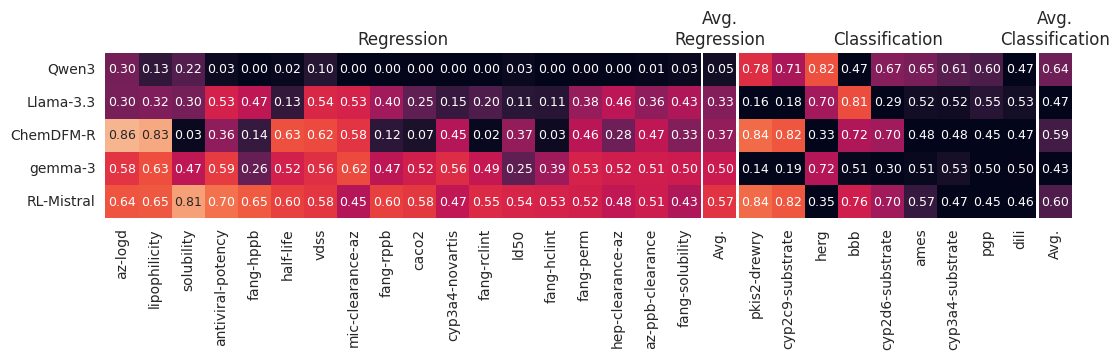

In [277]:
n_tot_cols = table.Task.nunique() + 2
n_rows = table.Model.nunique()

reg_ratio = table[table.objectives == "regression"].Task.nunique() / n_tot_cols
cls_ratio = table[table.objectives == "classification"].Task.nunique() / n_tot_cols

fig, axes = plt.subplots(
    1,
    4,
    figsize = (0.43*n_tot_cols,0.43 * n_rows),
    sharey=True,
    gridspec_kw = {
        "width_ratios":[reg_ratio, 1/n_tot_cols, cls_ratio,  1/n_tot_cols],
        "wspace":0.01,
    }
)

plot_heatmap(table, [axes[0],axes[1]], "Regression", "regression", annot_size=9)
plot_heatmap(table, [axes[2],axes[3]], "Classification", "classification", vmin = 0.5, vmax=1, annot_size= 9)

for ax in axes[1:]:
    ax.set_ylabel("")

fig.savefig(f"{FIG_PATH}/molecular_proppred_heatmap.pdf", bbox_inches="tight")

# Radar Charts

In [252]:
REMOVE_MODELS = [
    "ether0", "R1-Llama", "R1-Qwen", "MiniMax-M2", "Qwen3"
]
TO_HIGHLIGHT = [
    "RL-Mistral", #"Qwen3-Next"
]

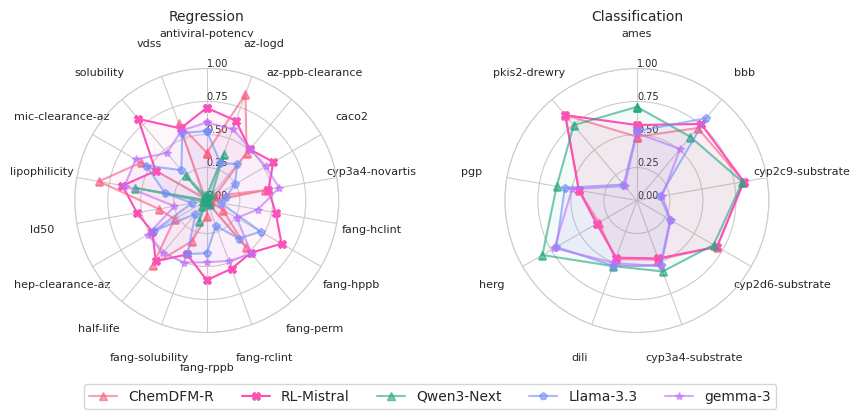

In [253]:
# Radar charts for classification and regression
from math import pi
from notebooks.utils import CMAP_MODELS, MARKER_MODELS


def plot_radar(ax, table, split_val, title, vmin=0, vmax=1):
    model_order = [m for m in CMAP_MODELS.keys() if not m in REMOVE_MODELS and m in table.Model.unique()]
    data = pd.pivot_table(table[table.objectives == split_val], KEY, "Model", "Task")
    categories = data.columns.tolist()
    n_cats = len(categories)

    # Compute angle for each category
    angles = [n / float(n_cats) * 2 * pi for n in range(n_cats)]
    angles += angles[:1]  # Complete the loop

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=8, zorder=120)

    # Move labels further from the plot to avoid overlap with grid
    ax.tick_params(axis='x', pad=15)

    # Draw ylabels
    ax.set_rlabel_position(0)
    yticks = np.linspace(vmin, vmax, 5)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{y:.2f}" for y in yticks], size=7)
    ax.set_ylim(vmin, vmax)

    # Plot each model
    for model in [m for m in CMAP_MODELS if m in model_order]:
        values = data.loc[model].tolist()
        values += values[:1]  # Complete the loop
        color = CMAP_MODELS.get(model, None)
        marker = MARKER_MODELS[model]  # Default to circle if not in MARKER_MODELS
        ax.plot(
            angles,
            values,
            linewidth=1.5,
            linestyle='solid',
            label=model,
            color=color,
            marker=marker,
            markersize=6,
            alpha = 1.0 if model in TO_HIGHLIGHT else 0.6
        )
        ax.fill(angles, values, alpha=0.05, color=color)

    ax.set_title(title, size=10, y=1.15)
    # Ensure tick labels are drawn on top
    for label in ax.get_xticklabels():
        label.set_zorder(0)
        label.set_bbox(dict(facecolor='white', edgecolor='none', alpha=1., pad=1.))

fig, axes = plt.subplots(1, 2, figsize=(9, 4), subplot_kw=dict(polar=True))

plot_radar(axes[0], table[~table.Model.isin(REMOVE_MODELS)], "regression", "Regression", vmin=0, vmax=1)
plot_radar(axes[1], table[~table.Model.isin(REMOVE_MODELS)], "classification", "Classification", vmin=0., vmax=1)

# Single legend below both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.07))

plt.tight_layout()
fig.savefig(f"{FIG_PATH}/molecular_proppred_radar.pdf", bbox_inches="tight")
plt.show()

In [254]:
LATEX_PATH = "/home/philippe/-Philippe-MolGenDocking/tables"